# Housing Prices Competition for Kaggle Learn Users, grajenje modelov

### Uvod

V tej skripti rešujemo regresijski problem iz Kaggle izziva, kjer je cilj napovedati cene na podlagi različnih vhodnih podatkov.  
Za ta namen uporabljam knjižnice, kot so **scikit-learn**, **XGBoost**, **CatBoost** in **LightGBM**, s katerimi zgradim več različnih modelov.

Poleg osnovnih regresorjev vključujem tudi **ensemble pristope**, kot sta `VotingRegressor` in `StackingRegressor`, da izboljšamo natančnost napovedi.  

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [5]:
train_df = pd.read_csv("./Podatki/train.csv")
test_df = pd.read_csv("./Podatki/test.csv")

In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Odstranjevanje osamelcev

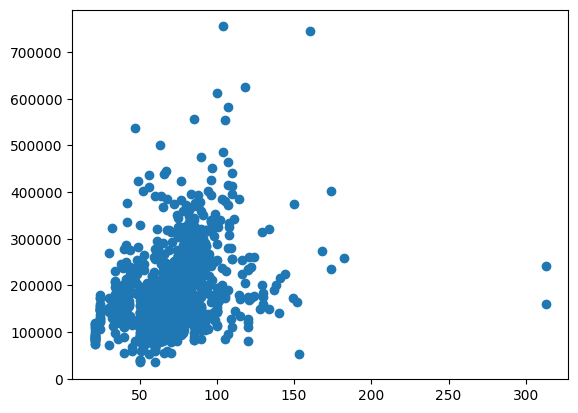

In [ ]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_df)
# LotFrontage: Linear feet of street connected to property

In [ ]:
train_df.query('LotFrontage > 300')
# Pregledal sem nekatere pomembne atribute kot LotArea, LotFrontage in izbrisal najdene osmalece
# 935, 1299, 250, 314, 336, 707, 
# morda: 1397, 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [ ]:
z_scores = pd.Series(stats.zscore(train_df['LotArea']))
z_scores.sort_values(ascending=False).head(10)
# iskanje z scora (za kok std je daleč od povprečja)

313     20.518273
335     15.448542
249     14.881285
706     10.486449
451      6.037793
1298     5.348867
1396     4.678682
769      4.308262
457      4.280500
384      4.268474
dtype: float64

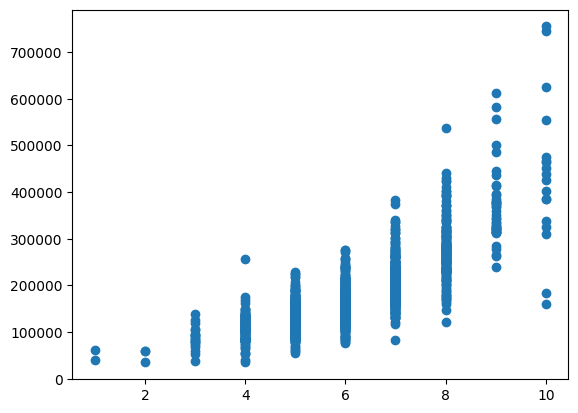

In [ ]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)
# Preštudiri še te osamelce npr za oceno 8un nad 500000 al pa 4 nad 200000

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


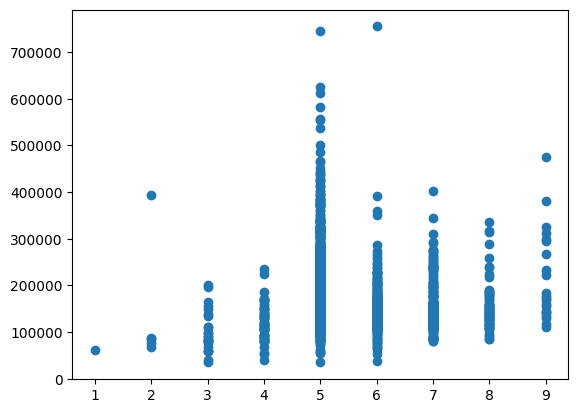

In [30]:
# we shold be dropping in the attributes that have a higher correlation
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)
train_df.query('OverallCond == 6 & SalePrice > 700000')
# ta ni tok pomemben attrib
# 379, 1183, 692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


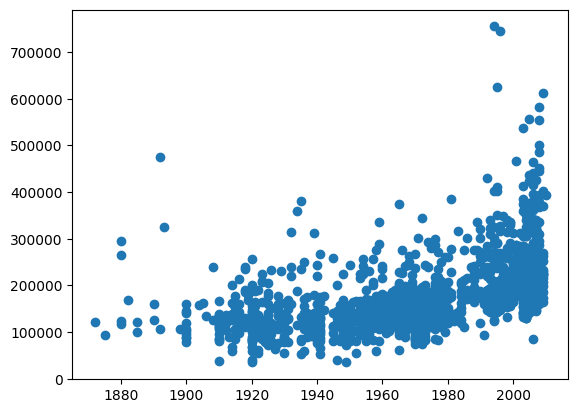

In [ ]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)
train_df.query('YearBuilt < 1900 & SalePrice > 400000')
#186

In [33]:
# Tukaj sem opravil še veliko več iskanja osamelcev
# Treba je tudi pasti, da ne kar odstranjuješ vse osamelce, 
# ker nekateri imajo lahko kakšne uporabne podatke

values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [32]:
# Odstranimo vrednosti
train_df = train_df[train_df.Id.isin(values) == False]

NameError: name 'values' is not defined